
## Set Up


In [1]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

# change path
%cd /content/drive/MyDrive/Medical-Report-Generator/Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Medical-Report-Generator/Notebooks


In [2]:
import os, re, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

!pip install pytorch-lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.optim import Adam

from tqdm.auto import tqdm


def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device, "| Torch:", torch.__version__, "| Lightning:", pl.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.6/831.6 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 40.8 MB/s eta 0:00:00
Device: cpu | Torch: 2.8.0+cu126 | Lightning: 2.5.6


## Hyperparameters

In [3]:
# ==== 2) HYPERPARAMETER CONFIGURATION ============================================
CFG = {
    # Data
    "max_src_len": 350, # max input text token length
    "max_tgt_len": 164, # max output summary token length
    "min_freq": 2, # minimumn token frequency to keep in vocabulary. else: <unk>
    "vocab_cap": 50_000,

    # Model
    "emb_dim": 256, # embedding vector size per token
    "enc_hidden": 512, # hidden state size per direction of BiLSTM encoder
    "enc_layers": 2, # stacked layers of encoder LSTM
    "enc_dropout": 0.3, # dropout for encoder LSTEM between layers
    "dec_hidden": 512, # decoder hidden state state size
    "dec_layers": 1, # decoder LSTM layers
    "dec_dropout": 0.3, # dropout for decoder LSTM between layers

    # Train
    "batch_size": 32, # number of examples per optimization step
    "lr": 1e-3, # learning rate
    "epochs": 10, # maximum epochs
    "grad_clip": 1.0, # prevent exploding gradient with max gradient norm = 1
    "precision": "16-mixed",
    "accumulate_grad_batches": 1,

    # Special Tokens
    "pad_token": "<pad>", # padding token for filling empty space
    "unk_token": "<unk>", #unkown tokens for tokens not in vocab
    "bos_token": "<bos>", # beginning of sequence
    "eos_token": "<eos>", # end of sequence
}
CFG


{'max_src_len': 350,
 'max_tgt_len': 164,
 'min_freq': 2,
 'vocab_cap': 50000,
 'emb_dim': 256,
 'enc_hidden': 512,
 'enc_layers': 2,
 'enc_dropout': 0.3,
 'dec_hidden': 512,
 'dec_layers': 1,
 'dec_dropout': 0.3,
 'batch_size': 32,
 'lr': 0.001,
 'epochs': 10,
 'grad_clip': 1.0,
 'precision': '16-mixed',
 'accumulate_grad_batches': 1,
 'pad_token': '<pad>',
 'unk_token': '<unk>',
 'bos_token': '<bos>',
 'eos_token': '<eos>'}

Load Data

In [4]:
### 4 LOAD CLEAN DATA SPLIT
train_path = "../Data/train.csv"
val_path = "../Data/val.csv"
test_path = "../Data/test.csv"

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

In [5]:
print("Splits:", len(train_df), len(val_df), len(test_df))

Splits: 112000 14000 14000


## Tokenization and Vocabulary

In [6]:
# ==== 5) TOKENIZATION & VOCAB =======================================
from collections import Counter

def tokenize(text):  # whitespace tokenizer
    return text.split()

def build_vocab(texts, cfg):
    counter = Counter() # initialize token counter

    # Increment token counts
    for t in texts:
        tokens = tokenize(t)
        counter.update(tokens)

    # Keep only tokens that meet the minimum frequency threshold
    items = []
    for word, count in counter.items():
        if count >= cfg["min_freq"]:
            items.append(word)

    # Cap vocabulary to most frequent tokens
    items.sort(key=lambda w: -counter[w]) # sort in descending order by frequency
    items = items[:cfg["vocab_cap"]] # cap vocabiulary

    # Build index-to-string mapping
    itos = [
        cfg["pad_token"], # padding
        cfg["unk_token"], # unkown
        cfg["bos_token"], # beginning of sentence
        cfg["eos_token"], # end of sentence
    ]
    for word in items:
        itos.append(word)

    # Build string-to-index mapping
    stoi = {}
    for index, word in enumerate(itos):
        stoi[word] = index

    return stoi, itos

# build vocabulary from training set
stoi, itos = build_vocab(
    train_df["source_text"].tolist() + train_df["target_text"].tolist(), CFG
)

vocab_size = len(itos)
pad_id, unk_id = stoi[CFG["pad_token"]], stoi[CFG["unk_token"]]
bos_id, eos_id = stoi[CFG["bos_token"]], stoi[CFG["eos_token"]]

print("Vocab size:", vocab_size)

Vocab size: 30151


# DataLoaders

In [9]:
# ==== 6) DATASET & DATALOADERS (PAD FIX) ============================
from torch.utils.data import Dataset, DataLoader

def tokenize(text: str):
    return text.split()

def numericalize(text, max_len, stoi, unk_id, bos_id=None, eos_id=None):
    toks = tokenize(text)[:max_len]
    ids = [stoi.get(t, unk_id) for t in toks]
    if bos_id is not None: ids = [bos_id] + ids
    if eos_id is not None: ids = ids + [eos_id]
    return ids

class ReportDataset(Dataset):
    def __init__(self, df, cfg, stoi, pad_id, unk_id, bos_id, eos_id):
        self.src = df["source_text"].tolist()
        self.tgt = df["target_text"].tolist()
        self.cfg = cfg
        self.stoi = stoi
        self.pad_id = pad_id
        self.unk_id = unk_id
        self.bos_id = bos_id
        self.eos_id = eos_id
    def __len__(self): return len(self.src)
    def __getitem__(self, i):
        src_ids = numericalize(self.src[i], self.cfg["max_src_len"], self.stoi, self.unk_id)
        tgt_ids = numericalize(self.tgt[i], self.cfg["max_tgt_len"], self.stoi, self.unk_id,
                               bos_id=self.bos_id, eos_id=self.eos_id)
        return {"src_ids": src_ids, "tgt_ids": tgt_ids, "ref": self.tgt[i]}

def collate_fn(batch):
    """Pads with the true pad_id and returns src_len for packing."""
    B = len(batch)
    src_max = max(len(b["src_ids"]) for b in batch)
    tgt_max = max(len(b["tgt_ids"]) for b in batch)

    src = torch.full((B, src_max), pad_id, dtype=torch.long)
    tgt_in  = torch.full((B, tgt_max-1), pad_id, dtype=torch.long)
    tgt_out = torch.full((B, tgt_max-1), pad_id, dtype=torch.long)
    src_len = torch.zeros(B, dtype=torch.long)
    refs = []

    for i, ex in enumerate(batch):
        s, t = ex["src_ids"], ex["tgt_ids"]
        src[i, :len(s)] = torch.tensor(s)
        if len(t) > 1:
            tgt_in[i, :len(t)-1]  = torch.tensor(t[:-1])
            tgt_out[i, :len(t)-1] = torch.tensor(t[1:])
        src_len[i] = len(s)
        refs.append(ex["ref"])

    return {"src": src, "src_len": src_len, "tgt_in": tgt_in, "tgt_out": tgt_out, "refs": refs}

train_ds = ReportDataset(train_df, CFG, stoi, pad_id, unk_id, bos_id, eos_id)
val_ds   = ReportDataset(val_df,   CFG, stoi, pad_id, unk_id, bos_id, eos_id)
test_ds  = ReportDataset(test_df,  CFG, stoi, pad_id, unk_id, bos_id, eos_id)

train_loader = DataLoader(train_ds, batch_size=CFG["batch_size"], shuffle=True,  collate_fn=collate_fn, pin_memory=True, num_workers=2, persistent_workers=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=2, persistent_workers=True)
test_loader  = DataLoader(test_ds,  batch_size=CFG["batch_size"], shuffle=False, collate_fn=collate_fn, pin_memory=True, num_workers=2, persistent_workers=True)


## Lightning (no attention)

In [10]:
# ==== 7) LIGHTNING MODULE (PACKED ENCODER) ==========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim import Adam
import torch.nn.utils.rnn as rnn_utils

class Seq2SeqLSTM(pl.LightningModule):
    """
    LSTM encoder–decoder (no attention), now with packed sequences so the
    encoder final state comes from the real last token (not padding).
    """
    def __init__(self, vocab_size, pad_id, cfg):
        super().__init__()
        self.save_hyperparameters(ignore=["vocab_size"])
        self.cfg = cfg
        self.pad_id = pad_id

        self.emb = nn.Embedding(vocab_size, cfg["emb_dim"], padding_idx=pad_id)

        self.encoder = nn.LSTM(
            input_size = cfg["emb_dim"],
            hidden_size = cfg["enc_hidden"],
            num_layers = cfg["enc_layers"],
            dropout = cfg["enc_dropout"] if cfg["enc_layers"] > 1 else 0.0,
            bidirectional = True,
            batch_first = True,
        )

        self.h_bridge = nn.Linear(cfg["enc_hidden"] * 2, cfg["dec_hidden"])
        self.c_bridge = nn.Linear(cfg["enc_hidden"] * 2, cfg["dec_hidden"])

        self.decoder = nn.LSTM(
            input_size = cfg["emb_dim"],
            hidden_size = cfg["dec_hidden"],
            num_layers = cfg["dec_layers"],
            dropout = cfg["dec_dropout"] if cfg["dec_layers"] > 1 else 0.0,
            batch_first = True,
        )

        self.out_proj = nn.Linear(cfg["dec_hidden"], vocab_size)

    def encode(self, src, src_len):
        """
        Packs the embedded source by true lengths so the encoder state is
        computed at the last *real* token for each sequence.
        """
        emb = self.emb(src)  # [B,S,d]
        packed = rnn_utils.pack_padded_sequence(
            emb, lengths=src_len.cpu(), batch_first=True, enforce_sorted=False
        )
        _, (h_n, c_n) = self.encoder(packed)  # final states per direction
        h_fwd, h_bwd = h_n[-2], h_n[-1]       # [B,H] each (last layer)
        c_fwd, c_bwd = c_n[-2], c_n[-1]
        h_cat = torch.cat([h_fwd, h_bwd], dim=-1)
        c_cat = torch.cat([c_fwd, c_bwd], dim=-1)
        h0 = torch.tanh(self.h_bridge(h_cat)).unsqueeze(0)  # [1,B,dec_H]
        c0 = torch.tanh(self.c_bridge(c_cat)).unsqueeze(0)  # [1,B,dec_H]
        return (h0, c0)

    def decode(self, tgt_in, state):
        emb = self.emb(tgt_in)          # [B,T,d]
        dec_out, _ = self.decoder(emb, state)
        logits = self.out_proj(dec_out) # [B,T,V]
        return logits

    def forward(self, batch):
        state = self.encode(batch["src"], batch["src_len"])
        return self.decode(batch["tgt_in"], state)

    def _loss(self, logits, tgt_out):
        B, T, V = logits.size()
        return F.cross_entropy(
            logits.reshape(B*T, V),
            tgt_out.reshape(B*T),
            ignore_index=self.pad_id,
        )

    def training_step(self, batch, _):
        loss = self._loss(self(batch), batch["tgt_out"])
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, _):
        loss = self._loss(self(batch), batch["tgt_out"])
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.cfg["lr"])


In [11]:
# # ARCHIVE greedy ==== 7) LIGHTNING MODULE ===========================================
# import torch.nn as nn
# import torch.nn.functional as F
# import pytorch_lightning as pl
# from torch.optim import Adam
# import torch.nn.utils.rnn as rnn_utils

# class Seq2SeqLSTM(pl.LightningModule):
#     """
#     Minimal encoder–decoder (no attention):
#       - Shared token embedding for encoder & decoder
#       - Bidirectional LSTM encoder -> bridge to decoder state
#       - Unrolled decoder with teacher forcing during training
#       - Token-level cross-entropy loss, padding ignored
#     """
#     def __init__(self, vocab_size, pad_id, cfg):
#         super().__init__()
#         self.save_hyperparameters(ignore=["vocab_size"])  # keep cfg/pad_id in checkpoint
#         self.cfg = cfg
#         self.pad_id = pad_id

#         # 1) Embedding: maps token IDs -> vectors. padding_idx makes pad always zeroed
#         self.emb = nn.Embedding(vocab_size, cfg["emb_dim"], padding_idx=pad_id)

#         # 2) Encoder: BiLSTM reads the source sequence; we keep only final layer states
#         self.encoder = nn.LSTM(
#             input_size = cfg["emb_dim"],
#             hidden_size = cfg["enc_hidden"],
#             num_layers = cfg["enc_layers"],
#             dropout = cfg["enc_dropout"] if cfg["enc_layers"] > 1 else 0.0,
#             bidirectional = True,
#             batch_first = True,
#         )

#         # 3) Bridge: concat(forward, backward) -> decoder hidden size (simple linear + tanh)
#         self.h_bridge = nn.Linear(cfg["enc_hidden"] * 2, cfg["dec_hidden"])
#         self.c_bridge = nn.Linear(cfg["enc_hidden"] * 2, cfg["dec_hidden"])

#         # 4) Decoder: unidirectional LSTM produces a hidden vector per time step
#         self.decoder = nn.LSTM(
#             input_size = cfg["emb_dim"],
#             hidden_size = cfg["dec_hidden"],
#             num_layers = cfg["dec_layers"],
#             dropout = cfg["dec_dropout"] if cfg["dec_layers"] > 1 else 0.0,
#             batch_first = True,
#         )

#         # 5) Output layer: maps decoder hidden -> vocabulary logits
#         self.out_proj = nn.Linear(cfg["dec_hidden"], vocab_size)

#     # -------- Core ops --------


#     def encode(self, src, src_len):
#       emb = self.emb(src)  # [B,S,d]
#       # pack by true lengths (descending order not required with enforce_sorted=False)
#       packed = rnn_utils.pack_padded_sequence(
#           emb, lengths=src_len.cpu(), batch_first=True, enforce_sorted=False
#       )
#       enc_out, (h_n, c_n) = self.encoder(packed)
#       # h_n/c_n already correspond to the last *real* token per sequence now
#       h_fwd, h_bwd = h_n[-2], h_n[-1]   # [B, H] each (last layer’s fwd/bwd)
#       c_fwd, c_bwd = c_n[-2], c_n[-1]
#       h_cat = torch.cat([h_fwd, h_bwd], dim=-1)
#       c_cat = torch.cat([c_fwd, c_bwd], dim=-1)
#       h0 = torch.tanh(self.h_bridge(h_cat)).unsqueeze(0)  # [1,B,dec_H]
#       c0 = torch.tanh(self.c_bridge(c_cat)).unsqueeze(0)  # [1,B,dec_H]
#       return (h0, c0)
#     # def encode(self, src, src_len):
#     #     """
#     #     src:     [B, S] token IDs
#     #     src_len: [B]    (not used here for packing to keep code simple)
#     #     Returns initial decoder state (h0, c0) after bridging the encoder's final states.
#     #     """
#     #     emb = self.emb(src)                      # [B, S, d]
#     #     enc_out, (h_n, c_n) = self.encoder(emb) # h_n/c_n: [2*L, B, H] with biLSTM
#     #     # split last layer's forward/backward states, then bridge to decoder size
#     #     h_fwd, h_bwd = h_n[-2], h_n[-1]         # [B, H] each
#     #     c_fwd, c_bwd = c_n[-2], c_n[-1]
#     #     h_cat = torch.cat([h_fwd, h_bwd], dim=-1)
#     #     c_cat = torch.cat([c_fwd, c_bwd], dim=-1)
#     #     h0 = torch.tanh(self.h_bridge(h_cat)).unsqueeze(0)  # [1, B, dec_H]
#     #     c0 = torch.tanh(self.c_bridge(c_cat)).unsqueeze(0)  # [1, B, dec_H]
#     #     return (h0, c0)

#     def decode(self, tgt_in, state):
#         """
#         tgt_in: [B, T] teacher-forced inputs (starts with <bos>)
#         state:  (h0, c0) initial decoder state
#         Returns token logits for each time step: [B, T, V]
#         """
#         emb = self.emb(tgt_in)         # [B, T, d]
#         dec_out, _ = self.decoder(emb, state)
#         logits = self.out_proj(dec_out)  # [B, T, V]
#         return logits

#     # -------- Lightning plumbing --------
#     def forward(self, batch):
#         """Compute logits for a batch (called in training/validation steps)."""
#         state = self.encode(batch["src"], batch["src_len"])
#         return self.decode(batch["tgt_in"], state)

#     def _loss(self, logits, tgt_out):
#         """
#         Cross-entropy over next-token targets; padding positions ignored.
#         logits: [B, T, V]  tgt_out: [B, T]
#         """
#         B, T, V = logits.size()
#         return F.cross_entropy(
#             logits.reshape(B*T, V),
#             tgt_out.reshape(B*T),
#             ignore_index=self.pad_id,
#         )

#     def training_step(self, batch, _):
#         loss = self._loss(self(batch), batch["tgt_out"])
#         self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
#         return loss

#     def validation_step(self, batch, _):
#         loss = self._loss(self(batch), batch["tgt_out"])
#         self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

#     def configure_optimizers(self):
#         return Adam(self.parameters(), lr=self.cfg["lr"])


In [12]:
# from collections import Counter
# Counter(test_df["target_text"]).most_common(10)[:5]


In [13]:
# # ARCHIVE ==== 7) LIGHTNING MODULE ===========================================

# class Seq2SeqNoAttentionLit(pl.LightningModule):
#     def __init__(self, vocab_size, pad_id, cfg):
#         super().__init__()
#         self.save_hyperparameters(ignore=["stoi", "itos"])  # for checkpointing
#         self.cfg = cfg
#         self.pad_id = pad_id

#         # Embedding
#         self.emb = nn.Embedding(vocab_size, cfg["emb_dim"], padding_idx=pad_id)

#         # Encoder (BiLSTM)
#         self.encoder = nn.LSTM(
#             input_size=cfg["emb_dim"],
#             hidden_size=cfg["enc_hidden"],
#             num_layers=cfg["enc_layers"],
#             dropout=cfg["enc_dropout"] if cfg["enc_layers"] > 1 else 0.0,
#             bidirectional=True,
#             batch_first=True,
#         )

#         # Bridge: 2*enc_hidden -> dec_hidden
#         self.h_bridge = nn.Linear(cfg["enc_hidden"] * 2, cfg["dec_hidden"])
#         self.c_bridge = nn.Linear(cfg["enc_hidden"] * 2, cfg["dec_hidden"])

#         # Decoder
#         self.decoder = nn.LSTM(
#             input_size=cfg["emb_dim"],
#             hidden_size=cfg["dec_hidden"],
#             num_layers=cfg["dec_layers"],
#             dropout=cfg["dec_dropout"] if cfg["dec_layers"] > 1 else 0.0,
#             batch_first=True,
#         )

#         # Output projection
#         self.out_proj = nn.Linear(cfg["dec_hidden"], vocab_size)

#     # ---- core ops ----
#     def encode(self, src, src_len):
#         emb = self.emb(src)                # [B, T, d]
#         enc_out, (h_n, c_n) = self.encoder(emb)
#         h_fwd, h_bwd = h_n[-2], h_n[-1]    # top layer forward/backward
#         c_fwd, c_bwd = c_n[-2], c_n[-1]
#         h_cat = torch.cat([h_fwd, h_bwd], dim=-1)
#         c_cat = torch.cat([c_fwd, c_bwd], dim=-1)
#         h0 = torch.tanh(self.h_bridge(h_cat)).unsqueeze(0)  # [1,B,H]
#         c0 = torch.tanh(self.c_bridge(c_cat)).unsqueeze(0)  # [1,B,H]
#         return (h0, c0)

#     def decode(self, tgt_in, state):
#         emb = self.emb(tgt_in)             # [B, T-1, d]
#         dec_out, _ = self.decoder(emb, state)
#         logits = self.out_proj(dec_out)    # [B, T-1, V]
#         return logits

#     # ---- Lightning hooks ----
#     def forward(self, batch):
#         state = self.encode(batch["src"], batch["src_len"])
#         logits = self.decode(batch["tgt_in"], state)
#         return logits

#     def compute_loss(self, logits, tgt_out):
#         # logits: [B,T,V]  tgt_out: [B,T]
#         B, T, V = logits.size()
#         loss = F.cross_entropy(
#             logits.reshape(B*T, V),
#             tgt_out.reshape(B*T),
#             ignore_index=self.pad_id,
#         )
#         return loss

#     def training_step(self, batch, batch_idx):
#         logits = self(batch)
#         loss = self.compute_loss(logits, batch["tgt_out"])
#         self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
#         return loss

#     def validation_step(self, batch, batch_idx):
#         logits = self(batch)
#         loss = self.compute_loss(logits, batch["tgt_out"])
#         self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

#     def configure_optimizers(self):
#         return Adam(self.parameters(), lr=self.cfg["lr"])


## Attention

### Lightning (Attention)

In [31]:
# ==== 7) LIGHTNING MODULE (Luong dot ATTENTION, FIXED) =============
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.optim import Adam
import torch.nn.utils.rnn as rnn_utils

class Seq2SeqLSTM_Attn(pl.LightningModule):
    """
    BiLSTM encoder + LSTM decoder with Luong 'dot' attention.
    - Packs encoder by true lengths.
    - Projects encoder time-steps (2*Henc) -> Hdec before dot-product.
    - Concats [decoder_hidden || attention_context] to predict next token.
    """
    def __init__(self, vocab_size, pad_id, cfg):
        super().__init__()
        self.save_hyperparameters(ignore=["vocab_size"])
        self.cfg = cfg
        self.pad_id = pad_id

        d_emb = cfg["emb_dim"]; Henc = cfg["enc_hidden"]; Hdec = cfg["dec_hidden"]

        self.emb = nn.Embedding(vocab_size, d_emb, padding_idx=pad_id)

        self.encoder = nn.LSTM(
            input_size=d_emb, hidden_size=Henc, num_layers=cfg["enc_layers"],
            dropout=cfg["enc_dropout"] if cfg["enc_layers"] > 1 else 0.0,
            bidirectional=True, batch_first=True
        )

        # Bridge 2*Henc -> Hdec
        self.h_bridge = nn.Linear(2*Henc, Hdec)
        self.c_bridge = nn.Linear(2*Henc, Hdec)

        self.decoder = nn.LSTM(
            input_size=d_emb, hidden_size=Hdec, num_layers=cfg["dec_layers"],
            dropout=cfg["dec_dropout"] if cfg["dec_layers"] > 1 else 0.0,
            batch_first=True
        )

        # *** NEW: project encoder outputs to Hdec for Luong dot ***
        self.enc_proj = nn.Linear(2*Henc, Hdec, bias=False)

        # Output sees [Hdec || 2*Henc] (we use *unprojected* context for richness)
        self.out_proj = nn.Linear(Hdec + 2*Henc, vocab_size)

        # Label smoothing helps reduce generic collapse
        self.ce = nn.CrossEntropyLoss(ignore_index=pad_id, label_smoothing=0.1)

    # ---- encoder ----
    def encode(self, src, src_len):
        emb = self.emb(src)  # [B,S,d]
        packed = rnn_utils.pack_padded_sequence(
            emb, lengths=src_len.cpu(), batch_first=True, enforce_sorted=False
        )
        enc_packed, (h_n, c_n) = self.encoder(packed)
        enc_out, _ = rnn_utils.pad_packed_sequence(enc_packed, batch_first=True)  # [B,S,2Henc]

        h_fwd, h_bwd = h_n[-2], h_n[-1]
        c_fwd, c_bwd = c_n[-2], c_n[-1]
        h_cat = torch.cat([h_fwd, h_bwd], dim=-1)
        c_cat = torch.cat([c_fwd, c_bwd], dim=-1)
        h0 = torch.tanh(self.h_bridge(h_cat)).unsqueeze(0)  # [1,B,Hdec]
        c0 = torch.tanh(self.c_bridge(c_cat)).unsqueeze(0)  # [1,B,Hdec]

        enc_mask = (src != self.pad_id)  # [B,S]
        return enc_out, enc_mask, (h0, c0)

    # ---- attention helper ----
    def attend(self, dec_out, enc_out, enc_mask):
        """
        dec_out: [B,T,Hdec]
        enc_out: [B,S,2Henc]  -> project to [B,S,Hdec] for dot-product
        """
        enc_proj = self.enc_proj(enc_out)               # [B,S,Hdec]
        scores = torch.bmm(dec_out, enc_proj.transpose(1, 2))  # [B,T,S]
        scores = scores.masked_fill(~enc_mask.unsqueeze(1), float("-inf"))
        attn = torch.softmax(scores, dim=-1)            # [B,T,S]
        context = torch.bmm(attn, enc_out)              # [B,T,2Henc]  (use unprojected for context)
        return context

    # ---- teacher-forced pass ----
    def decode_tf(self, tgt_in, state, enc_out, enc_mask):
        emb = self.emb(tgt_in)                          # [B,T,d]
        dec_out, _ = self.decoder(emb, state)           # [B,T,Hdec]
        ctx = self.attend(dec_out, enc_out, enc_mask)   # [B,T,2Henc]
        logits = self.out_proj(torch.cat([dec_out, ctx], dim=-1))  # [B,T,V]
        return logits

    # ---- Lightning plumbing ----
    def forward(self, batch):
        enc_out, enc_mask, state = self.encode(batch["src"], batch["src_len"])
        return self.decode_tf(batch["tgt_in"], state, enc_out, enc_mask)

    def training_step(self, batch, _):
        enc_out, enc_mask, state = self.encode(batch["src"], batch["src_len"])
        logits = self.decode_tf(batch["tgt_in"], state, enc_out, enc_mask)
        B, T, V = logits.size()
        loss = self.ce(logits.reshape(B*T, V), batch["tgt_out"].reshape(B*T))
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, _):
        enc_out, enc_mask, state = self.encode(batch["src"], batch["src_len"])
        logits = self.decode_tf(batch["tgt_in"], state, enc_out, enc_mask)
        B, T, V = logits.size()
        loss = self.ce(logits.reshape(B*T, V), batch["tgt_out"].reshape(B*T))
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=self.cfg["lr"])



### Decoder(Attention)

In [36]:
# ==== 9) DECODERS (attention) — use model.enc_proj ==================
@torch.no_grad()
def greedy_decode_attn(model, src_ids, max_len, bos_id, eos_id):
    model.eval()
    dev = model.device
    src = src_ids.unsqueeze(0).to(dev)
    src_len = torch.tensor([src.size(1)], dtype=torch.long, device=dev)
    enc_out, enc_mask, state = model.encode(src, src_len)
    enc_proj = model.enc_proj(enc_out)  # [B,S,Hdec]

    y = torch.tensor([[bos_id]], dtype=torch.long, device=dev)
    out = []
    for _ in range(max_len):
        dec_out, state = model.decoder(model.emb(y[:, -1:]), state)        # [1,1,Hdec]
        scores = torch.bmm(dec_out, enc_proj.transpose(1, 2))               # [1,1,S]
        scores = scores.masked_fill(~enc_mask.unsqueeze(1), float("-inf"))
        attn = torch.softmax(scores, dim=-1)
        ctx = torch.bmm(attn, enc_out)                                      # [1,1,2Henc]
        logits = model.out_proj(torch.cat([dec_out, ctx], dim=-1))          # [1,1,V]
        next_id = int(torch.argmax(logits[:, -1, :], dim=-1).item())
        if next_id == eos_id: break
        out.append(next_id)
        y = torch.cat([y, torch.tensor([[next_id]], device=dev)], dim=1)
    return out

@torch.no_grad()
def beam_search_decode_attn(model, src_ids, max_len, bos_id, eos_id, beam_size=5, len_norm=0.7):
    dev = model.device
    src = src_ids.unsqueeze(0).to(dev)                                   # [1,S]
    src_len = torch.tensor([src.size(1)], dtype=torch.long, device=dev)
    enc_out, enc_mask, init_state = model.encode(src, src_len)           # enc_out: [1,S,2Henc]
    enc_proj = model.enc_proj(enc_out)                                   # [1,S,Hdec]

    # Each beam = (tokens 1D LongTensor, cumulative_logprob, state)
    beams = [(torch.tensor([bos_id], device=dev), 0.0, init_state)]

    for _ in range(max_len):
        new_beams = []
        for toks, logp, state in beams:
            if toks[-1].item() == eos_id:
                new_beams.append((toks, logp, state))
                continue

            # one-step decode from last token
            emb_last = model.emb(toks[-1:].unsqueeze(0))                  # [1,1,d]
            dec_out, new_state = model.decoder(emb_last, state)           # [1,1,Hdec]

            # attention over encoder
            scores = torch.bmm(dec_out, enc_proj.transpose(1, 2))        # [1,1,S]
            scores = scores.masked_fill(~enc_mask.unsqueeze(1), float("-inf"))
            attn = torch.softmax(scores, dim=-1)                          # [1,1,S]
            ctx = torch.bmm(attn, enc_out)                                # [1,1,2Henc]

            # logits -> 1D [V]
            logits = model.out_proj(torch.cat([dec_out, ctx], dim=-1))    # [1,1,V]
            logits = logits[0, -1, :]                                     # [V]

            lp = torch.log_softmax(logits, dim=-1)                        # [V]
            topk_vals, topk_idx = torch.topk(lp, beam_size)               # [beam_size], [beam_size]

            for nid, val in zip(topk_idx.tolist(), topk_vals.tolist()):
                nlp = logp + float(val)
                new_toks = torch.cat([toks, torch.tensor([nid], device=dev)])
                new_beams.append((new_toks, nlp, new_state))

        # keep best beams by length-normalized score
        def score(b):
            t, lp, _ = b
            L = max(1, (t.ne(bos_id) & t.ne(eos_id)).sum().item())
            return lp / (L ** len_norm)

        beams = sorted(new_beams, key=score, reverse=True)[:beam_size]
        if all(b[0][-1].item() == eos_id for b in beams):
            break

    best = max(beams, key=lambda b: b[1])
    ids = [i for i in best[0].tolist() if i not in (bos_id, eos_id)]
    return ids




### Decoder with attention

In [33]:
# ==== 10) GENERATE (attention model) =================================
from tqdm.auto import tqdm

@torch.no_grad()
def generate_texts_attn(model, loader, max_len, bos_id, eos_id, pad_id, itos,
                        use_beam=True, beam_size=5, len_norm=0.7):
    refs, hyps = [], []
    for batch in tqdm(loader, desc="Generating (attn)"):
        B = batch["src"].size(0)
        for i in range(B):
            src_ids = batch["src"][i][: batch["src_len"][i]].long().cpu()
            if use_beam:
                hyp_ids = beam_search_decode_attn(model, src_ids, max_len, bos_id, eos_id,
                                                  beam_size=beam_size, len_norm=len_norm)
            else:
                hyp_ids = greedy_decode_attn(model, src_ids, max_len, bos_id, eos_id)
            hyps.append(detok(hyp_ids, itos, special_ids=(bos_id, eos_id, pad_id)))
            refs.append(batch["refs"][i])
    return refs, hyps


### training and evaluation with attention

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | emb      | Embedding        | 7.7 M  | train
1 | encoder  | LSTM             | 9.5 M  | train
2 | h_bridge | Linear           | 524 K  | train
3 | c_bridge | Linear           | 524 K  | train
4 | decoder  | LSTM             | 1.6 M  | train
5 | enc_proj | Linear           | 524 K  | train
6 | out_proj | Linear           | 46.3 M | train
7 | ce       | CrossEntropyLoss | 0      | train
------------------------------------------------------
66.7 M    Trainable params
0         Non-trainable params
66.7 M 

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 3.381


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.205 >= min_delta = 0.0. New best score: 3.175


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 3.091


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 3.057


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 3.045


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 3.045. Signaling Trainer to stop.


Best checkpoint (attn): /content/drive/MyDrive/Medical-Report-Generator/Notebooks/lightning_logs/version_11/checkpoints/attn-best.ckpt


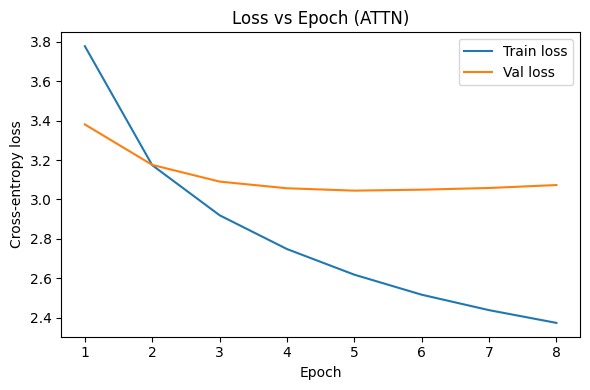

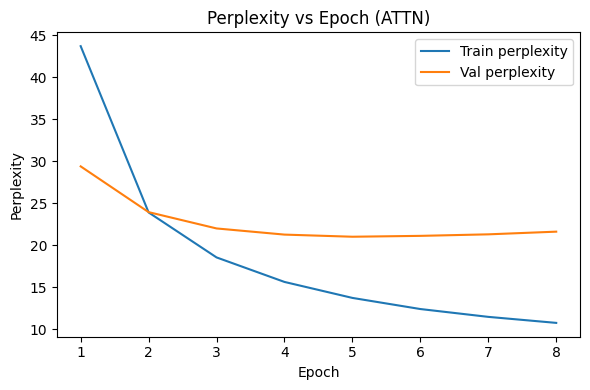

In [34]:
# ==== 8A) TRAIN Seq2SeqLSTM_Attn (EarlyStopping + plots) ===========
import math, torch, matplotlib.pyplot as plt, pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback

# --- history callback (robust to sanity-check) ---
class LossHistory(Callback):
    def __init__(self): self.train, self.val = [], []
    def on_train_epoch_end(self, trainer, pl_module):
        v = trainer.callback_metrics.get("train_loss")
        if v is not None: self.train.append(float(v.detach().cpu()))
    def on_validation_epoch_end(self, trainer, pl_module):
        if getattr(trainer, "sanity_checking", False):  # skip preflight
            return
        v = trainer.callback_metrics.get("val_loss")
        if v is not None: self.val.append(float(v.detach().cpu()))

hist_cb = LossHistory()
ckpt_cb = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="attn-best")
early_stop_cb = EarlyStopping(monitor="val_loss", mode="min",
                              patience=CFG.get("early_stop_patience", 3), verbose=True)

# <<< swap in the ATTENTION model >>>
model = Seq2SeqLSTM_Attn(vocab_size=vocab_size, pad_id=pad_id, cfg=CFG)

trainer = pl.Trainer(
    max_epochs=CFG["epochs"],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision=CFG["precision"],
    gradient_clip_val=CFG["grad_clip"],
    callbacks=[ckpt_cb, hist_cb, early_stop_cb],
    log_every_n_steps=50,
    num_sanity_val_steps=0,   # optional: avoids pre-epoch val logging
)

trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
best_path = ckpt_cb.best_model_path
print("Best checkpoint (attn):", best_path or "(none)")

# ---- plots (dimension-safe) ----
n = min(len(hist_cb.train), len(hist_cb.val))
if n > 0:
    tr = hist_cb.train[:n]; va = hist_cb.val[:n]
    epochs = range(1, n+1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, tr, label="Train loss")
    plt.plot(epochs, va, label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Cross-entropy loss"); plt.title("Loss vs Epoch (ATTN)")
    plt.legend(); plt.tight_layout(); plt.show()

    tr_pp = [math.exp(x) for x in tr]; va_pp = [math.exp(x) for x in va]
    plt.figure(figsize=(6,4))
    plt.plot(epochs, tr_pp, label="Train perplexity")
    plt.plot(epochs, va_pp, label="Val perplexity")
    plt.xlabel("Epoch"); plt.ylabel("Perplexity"); plt.title("Perplexity vs Epoch (ATTN)")
    plt.legend(); plt.tight_layout(); plt.show()
else:
    print("No epoch losses recorded (check logging keys).")


Generating (attn):   0%|          | 0/438 [00:00<?, ?it/s]

calculating scores...
computing bert embedding.


  0%|          | 0/409 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/438 [00:00<?, ?it/s]

done in 16.03 seconds, 873.17 sentences/sec
BERTScore — P: 0.8421  R: 0.8034  F1: 0.8199
ROUGE — R1: 0.5702  R2: 0.4380  RL: 0.5545


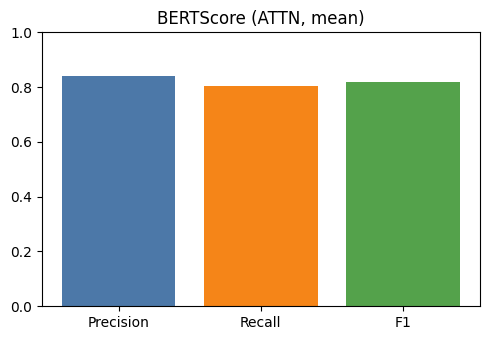

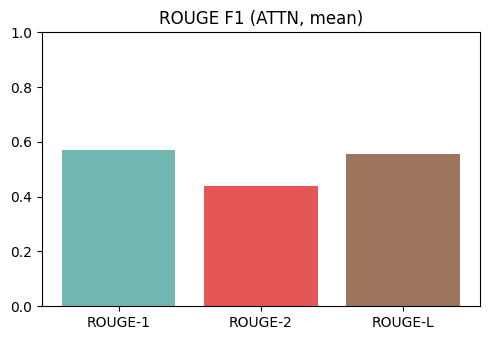

,reference,hypothesis,bert_precision,bert_recall,bert_f1,rouge1_f1,rouge2_f1,rougeL_f1
0,1. Bilateral pulmonary nodules consistent with...,1. No acute cardiopulmonary abnormalities. 2. ...,0.810556,0.785711,0.797940,0.347826,0.095238,0.347826
1,Evidence of emphysema and bronchitis. No focal...,Pulmonary emphysema. No focal air space disease.,0.826465,0.815637,0.821015,0.533333,0.153846,0.533333
2,Patchy airspace opacity in the left lower lobe...,Left lower lobe pneumonia.,0.828951,0.654826,0.731671,0.400000,0.307692,0.400000
3,Similar findings of cardiomegaly without super...,No acute cardiopulmonary disease.,0.845360,0.628113,0.720721,0.320000,0.173913,0.240000
4,Improving hazy airspace disease at the right l...,Please see above.,0.585285,0.444938,0.505552,0.000000,0.000000,0.000000
5,Patchy airspace opacities consistent with the ...,Patchy airspace opacities consistent with the ...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,No evidence of active disease. Negative for pn...,No active cardiopulmonary disease.,0.827163,0.752351,0.787985,0.500000,0.000000,0.500000
7,No evidence of acute cardiopulmonary disease.,No evidence of acute cardiopulmonary disease.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
8,Low lung volumes and probable left lower lobe ...,Low lung volumes with probable mild left lower...,0.921007,0.862058,0.890558,0.666667,0.454545,0.666667
9,Atelectasis in the bases.,No acute chest findings.,0.638147,0.624733,0.631369,0.000000,0.000000,0.000000


Saved full eval to: ../Data/attn_eval_full.csv
Saved 20 samples to: ../Data/attn_eval_samples20.csv


In [37]:
# ==== 10A) EVAL ATTENTION MODEL: beam gen + BERT/ROUGE + samples ===
!pip -q install bert-score rouge-score

import torch, pandas as pd, matplotlib.pyplot as plt
from bert_score import score as bertscore
from rouge_score import rouge_scorer

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load best attention checkpoint
assert best_path and "attn-best" in best_path, "Train Cell A first to produce an attention checkpoint."
model = Seq2SeqLSTM_Attn.load_from_checkpoint(
    best_path, vocab_size=vocab_size, pad_id=pad_id, cfg=CFG
).to(device).eval()

# --- generate with BEAM SEARCH (attention helper) ---
refs, hyps = generate_texts_attn(
    model, test_loader, CFG["max_tgt_len"], bos_id, eos_id, pad_id, itos,
    use_beam=True, beam_size=5, len_norm=0.7
)

# --- metrics ---
bio_model = "allenai/scibert_scivocab_uncased"
P, R, F1 = bertscore(
    hyps, refs, model_type=bio_model, lang="en",
    device=device, rescale_with_baseline=False, batch_size=32, verbose=True
)
p_mean, r_mean, f1_mean = float(P.mean()), float(R.mean()), float(F1.mean())
print(f"BERTScore — P: {p_mean:.4f}  R: {r_mean:.4f}  F1: {f1_mean:.4f}")

scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
r1_list, r2_list, rl_list = [], [], []
for ref, hyp in zip(refs, hyps):
    s = scorer.score(ref, hyp)
    r1_list.append(s["rouge1"].fmeasure)
    r2_list.append(s["rouge2"].fmeasure)
    rl_list.append(s["rougeLsum"].fmeasure)

r1_mean = float(sum(r1_list)/len(r1_list))
r2_mean = float(sum(r2_list)/len(r2_list))
rl_mean = float(sum(rl_list)/len(rl_list))
print(f"ROUGE — R1: {r1_mean:.4f}  R2: {r2_mean:.4f}  RL: {rl_mean:.4f}")

# --- compact plots ---
plt.figure(figsize=(5,3.5))
plt.bar(["Precision","Recall","F1"], [p_mean, r_mean, f1_mean],
        color=["#4C78A8","#F58518","#54A24B"])
plt.title("BERTScore (ATTN, mean)"); plt.ylim(0,1); plt.tight_layout(); plt.show()

plt.figure(figsize=(5,3.5))
plt.bar(["ROUGE-1","ROUGE-2","ROUGE-L"], [r1_mean, r2_mean, rl_mean],
        color=["#72B7B2","#E45756","#9D755D"])
plt.title("ROUGE F1 (ATTN, mean)"); plt.ylim(0,1); plt.tight_layout(); plt.show()

# --- build full eval df + show 20 generated samples ---
df_eval = pd.DataFrame({
    "reference": refs,
    "hypothesis": hyps,
    "bert_precision": P.tolist(),
    "bert_recall": R.tolist(),
    "bert_f1": F1.tolist(),
    "rouge1_f1": r1_list,
    "rouge2_f1": r2_list,
    "rougeL_f1": rl_list,
})

# 20 samples (random) to eyeball generations
df_samples = df_eval.sample(n=min(20, len(df_eval)), random_state=42).reset_index(drop=True)
display(df_samples)

# Optional: save both
out_eval_csv = "../Data/attn_eval_full.csv"
out_samples_csv = "../Data/attn_eval_samples20.csv"
df_eval.to_csv(out_eval_csv, index=False)
df_samples.to_csv(out_samples_csv, index=False)
print(f"Saved full eval to: {out_eval_csv}")
print(f"Saved 20 samples to: {out_samples_csv}")


In [8]:
# load 20 smaple eval and sort by F1 bert score
df_eval2 = pd.read_csv("../Data/attn_eval_samples20.csv")
df_eval2 = df_eval.sort_values(by="bert_f1", ascending=False).reset_index(drop=True)
df_eval2

,reference,hypothesis,bert_precision,bert_recall,bert_f1,rouge1_f1,rouge2_f1,rougeL_f1
0,No evidence of acute cardiopulmonary disease.,No evidence of acute cardiopulmonary disease.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,Patchy airspace opacities consistent with the ...,Patchy airspace opacities consistent with the ...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,No edema or consolidation.,No edema or consolidation.,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,Low lung volumes and probable left lower lobe ...,Low lung volumes with probable mild left lower...,0.921007,0.862058,0.890558,0.666667,0.454545,0.666667
4,No acute cardiopulmonary disease. Specifically...,No acute cardiopulmonary disease.,0.956213,0.794775,0.868052,0.615385,0.545455,0.615385
5,Evidence of emphysema and bronchitis. No focal...,Pulmonary emphysema. No focal air space disease.,0.826465,0.815637,0.821015,0.533333,0.153846,0.533333
6,1. Bilateral pulmonary nodules consistent with...,1. No acute cardiopulmonary abnormalities. 2. ...,0.810556,0.785711,0.797940,0.347826,0.095238,0.347826
7,Normal chest for age.,Normal chest.,0.854671,0.744481,0.795780,0.666667,0.500000,0.666667
8,No evidence of active disease. Negative for pn...,No active cardiopulmonary disease.,0.827163,0.752351,0.787985,0.500000,0.000000,0.500000
9,Hypoventilation with increased bibasilar atele...,Bibasilar airspace disease most likely atelect...,0.770531,0.781884,0.776166,0.363636,0.000000,0.363636


In [12]:
# display 3 total samples. Index 1, index 9, index, 18
# change floating point  of numerical values in dataframe rounded to 2 decimals

df_display = df_eval2.iloc[[1,9,18]].copy()
# Select only the numerical columns for rounding
numerical_cols = df_display.select_dtypes(include=np.number).columns
df_display[numerical_cols] = df_display[numerical_cols].round(2)

display(df_display)

,reference,hypothesis,bert_precision,bert_recall,bert_f1,rouge1_f1,rouge2_f1,rougeL_f1
1,Patchy airspace opacities consistent with the ...,Patchy airspace opacities consistent with the ...,1.00,1.00,1.00,1.00,1.00,1.00
9,Hypoventilation with increased bibasilar atele...,Bibasilar airspace disease most likely atelect...,0.77,0.78,0.78,0.36,0.00,0.36
18,Atelectasis in the bases.,No acute chest findings.,0.64,0.62,0.63,0.00,0.00,0.00


## Training

In [14]:
#  ==== 8) TRAINING & PLOTS (with EarlyStopping) =====================
"""
Trains Seq2SeqLSTM with:
  - ModelCheckpoint: save best epoch by val_loss
  - EarlyStopping: stop when val_loss doesn't improve for N epochs
  - LossHistory: collect train/val losses for plotting
Also plots Loss and Perplexity vs Epoch (no TensorBoard needed).
"""

import math
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, Callback

# --- Callback to capture losses per epoch for plotting ---
# class LossHistory(Callback):
#     """Collects end-of-epoch train/val losses exposed via self.log()."""
#     def __init__(self):
#         self.train, self.val = [], []
#     def on_train_epoch_end(self, trainer, pl_module):
#         v = trainer.callback_metrics.get("train_loss")
#         if v is not None:
#             self.train.append(float(v.detach().cpu()))
#     def on_validation_epoch_end(self, trainer, pl_module):
#         v = trainer.callback_metrics.get("val_loss")
#         if v is not None:
#             self.val.append(float(v.detach().cpu()))

class LossHistory(Callback):
    def __init__(self):
        self.train, self.val = [], []

    def on_train_epoch_end(self, trainer, pl_module):
        v = trainer.callback_metrics.get("train_loss")
        if v is not None:
            self.train.append(float(v.detach().cpu()))

    def on_validation_epoch_end(self, trainer, pl_module):
        # <-- skip the pre-training sanity validation
        if getattr(trainer, "sanity_checking", False):
            return
        v = trainer.callback_metrics.get("val_loss")
        if v is not None:
            self.val.append(float(v.detach().cpu()))

# --- Instantiate model and callbacks ---
hist_cb = LossHistory()
ckpt_cb = ModelCheckpoint(
    monitor="val_loss", mode="min", save_top_k=1, filename="best"
)

# If you want to configure patience, add CFG["early_stop_patience"] = 3 (for example)
patience = CFG.get("early_stop_patience", 3)
early_stop_cb = EarlyStopping(
    monitor="val_loss", mode="min", patience=patience, verbose=True
)

model = Seq2SeqLSTM(vocab_size=vocab_size, pad_id=pad_id, cfg=CFG)

trainer = pl.Trainer(
    max_epochs=CFG["epochs"],
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    precision=CFG["precision"],
    gradient_clip_val=CFG["grad_clip"],
    callbacks=[ckpt_cb, hist_cb, early_stop_cb],
    log_every_n_steps=50,
)

# --- Train ---
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
best_path = ckpt_cb.best_model_path
print("Best checkpoint:", best_path or "(none)")



INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:pytorch_lightning.c

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 16. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.499


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.121 >= min_delta = 0.0. New best score: 2.378


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 2.359


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 3 records. Best score: 2.359. Signaling Trainer to stop.


Best checkpoint: /content/drive/MyDrive/Medical-Report-Generator/Notebooks/lightning_logs/version_9/checkpoints/best.ckpt


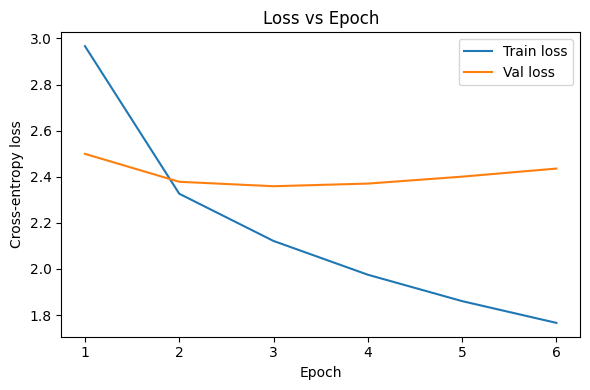

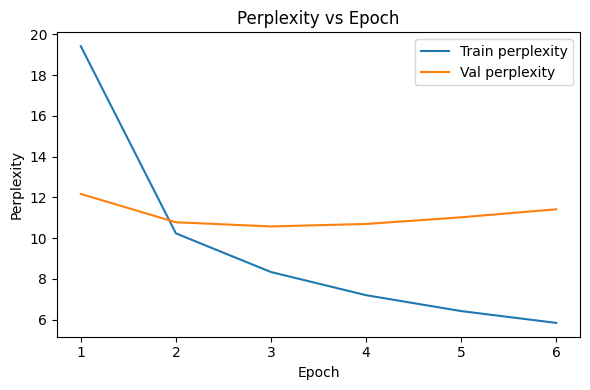

In [15]:
# --- Plot Loss and Perplexity (exp(loss)) vs Epoch ---
if hist_cb.train and hist_cb.val:
    epochs = range(1, len(hist_cb.train) + 1)

    plt.figure(figsize=(6,4))
    plt.plot(epochs, hist_cb.train, label="Train loss")
    plt.plot(epochs, hist_cb.val,   label="Val loss")
    plt.xlabel("Epoch"); plt.ylabel("Cross-entropy loss"); plt.title("Loss vs Epoch")
    plt.legend(); plt.tight_layout(); plt.show()

    tr_pp = [math.exp(x) for x in hist_cb.train]
    va_pp = [math.exp(x) for x in hist_cb.val]
    plt.figure(figsize=(6,4))
    plt.plot(epochs, tr_pp, label="Train perplexity")
    plt.plot(epochs, va_pp, label="Val perplexity")
    plt.xlabel("Epoch"); plt.ylabel("Perplexity"); plt.title("Perplexity vs Epoch")
    plt.legend(); plt.tight_layout(); plt.show()

In [16]:
# # ARCHIVE ==== 8) TRAIN + LOSS PLOTS =========================================
# import matplotlib.pyplot as plt
# import pytorch_lightning as pl
# from pytorch_lightning.callbacks import ModelCheckpoint, Callback

# class LossHistory(Callback):
#     def __init__(self):
#         super().__init__()
#         self.train = []
#         self.val = []
#     def on_train_epoch_end(self, trainer, pl_module):
#         # grab the epoch-logged value
#         if "train_loss" in trainer.callback_metrics:
#             self.train.append(float(trainer.callback_metrics["train_loss"].detach().cpu()))
#     def on_validation_epoch_end(self, trainer, pl_module):
#         if "val_loss" in trainer.callback_metrics:
#             self.val.append(float(trainer.callback_metrics["val_loss"].detach().cpu()))

# hist_cb = LossHistory()
# ckpt_cb = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1, filename="best")

# model = Seq2SeqNoAttentionLit(vocab_size=vocab_size, pad_id=pad_id, cfg=CFG)

# trainer = pl.Trainer(
#     max_epochs=CFG["epochs"],
#     accelerator="gpu" if torch.cuda.is_available() else "cpu",
#     devices=1,
#     precision=CFG["precision"],
#     gradient_clip_val=CFG["grad_clip"],
#     callbacks=[ckpt_cb, hist_cb],
#     log_every_n_steps=50,
# )

# trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
# best_path = ckpt_cb.best_model_path
# print("Best checkpoint:", best_path or "(none)")

# # --- Plot train/val losses ---
# if hist_cb.train and hist_cb.val:
#     plt.figure(figsize=(6,4))
#     plt.plot(hist_cb.train, label="train_loss")
#     plt.plot(hist_cb.val, label="val_loss")
#     plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training/Validation Loss")
#     plt.legend(); plt.tight_layout(); plt.show()


## Decoding

In [17]:
# ==== 9) DECODERS: GREEDY + BEAM SEARCH ============================
@torch.no_grad()
def greedy_decode(model, src_ids, max_len, bos_id, eos_id):
    """Simple baseline for comparison."""
    model.eval()
    device = model.device
    src = src_ids.unsqueeze(0).to(device)
    src_len = torch.tensor([src.size(1)], dtype=torch.long, device=device)
    state = model.encode(src, src_len)

    y = torch.tensor([[bos_id]], dtype=torch.long, device=device)
    out = []
    for _ in range(max_len):
        dec_out, state = model.decoder(model.emb(y[:, -1:]), state)
        logit = model.out_proj(dec_out[:, -1, :])
        next_id = int(torch.argmax(logit, dim=-1).item())
        if next_id == eos_id: break
        out.append(next_id)
        y = torch.cat([y, torch.tensor([[next_id]], device=device)], dim=1)
    return out

@torch.no_grad()
def beam_search_decode(model, src_ids, max_len, bos_id, eos_id, beam_size=5, len_norm=0.7):
    """
    Beam search with length normalization.
    Returns a list[int] of token IDs (without BOS/EOS).
    """
    model.eval()
    device = model.device
    src = src_ids.unsqueeze(0).to(device)
    src_len = torch.tensor([src.size(1)], dtype=torch.long, device=device)
    init_state = model.encode(src, src_len)

    # Each beam: (tokens 1D LongTensor, cumulative_logprob, state)
    beams = [(torch.tensor([bos_id], device=device), 0.0, init_state)]

    for _ in range(max_len):
        new_beams = []
        for tokens, logp, state in beams:
            if tokens[-1].item() == eos_id:
                new_beams.append((tokens, logp, state)); continue

            # decode one step from the last token
            emb_last = model.emb(tokens[-1:].unsqueeze(0))  # [1,1,d]
            dec_out, new_state = model.decoder(emb_last, state)  # [1,1,dec_H]
            logits = model.out_proj(dec_out[:, -1, :])           # [1,V]
            log_probs = torch.log_softmax(logits, dim=-1).squeeze(0)  # [V]

            topk_vals, topk_idx = torch.topk(log_probs, beam_size)
            for k in range(beam_size):
                nid = topk_idx[k].item()
                nlp = logp + topk_vals[k].item()
                new_tokens = torch.cat([tokens, torch.tensor([nid], device=device)])
                new_beams.append((new_tokens, nlp, new_state))

        # keep best beams by length-normalized score
        def score(b):
            toks, lp, _ = b
            L = max(1, (toks.ne(bos_id) & toks.ne(eos_id)).sum().item())
            return lp / (L ** len_norm)

        beams = sorted(new_beams, key=score, reverse=True)[:beam_size]
        if all(b[0][-1].item() == eos_id for b in beams):
            break

    best = max(beams, key=lambda b: b[1])  # highest raw logprob
    out = best[0].tolist()
    # strip BOS/EOS
    out = [i for i in out if i not in (bos_id, eos_id)]
    return out

def detokenize(ids, itos, special_ids=(None,)):
    toks = []
    skip = set(x for x in special_ids if x is not None)
    for i in ids:
        if i in skip: continue
        toks.append(itos[i] if 0 <= i < len(itos) else CFG["unk_token"])
    return " ".join(toks)


In [18]:
# # ARCHIVE GREEDY ==== 9) DECODING (GREEDY) ==========================================
# @torch.no_grad()
# def greedy_decode(model, src_ids, max_len, bos_id, eos_id, pad_id):
#     """
#     Run the decoder one step at a time, always picking argmax (greedy).
#     src_ids: 1D CPU LongTensor of source IDs (no padding)
#     Returns: list[int] token IDs (without BOS/EOS)
#     """
#     model.eval()
#     device = model.device
#     src = src_ids.unsqueeze(0).to(device)                          # [1, S]
#     src_len = torch.tensor([src.size(1)], dtype=torch.long, device=device)
#     state = model.encode(src, src_len)                             # (h0, c0)

#     y = torch.tensor([[bos_id]], dtype=torch.long, device=device)  # start with <bos>
#     out = []
#     for _ in range(max_len):
#         dec_out, state = model.decoder(model.emb(y[:, -1:]), state)  # last token only
#         logit = model.out_proj(dec_out[:, -1, :])                    # [1, V]
#         next_id = int(torch.argmax(logit, dim=-1).item())
#         if next_id == eos_id: break
#         out.append(next_id)
#         y = torch.cat([y, torch.tensor([[next_id]], device=device)], dim=1)
#     return out

# def detokenize(ids, itos, special_ids=(None,)):
#     """Map IDs -> tokens, drop special tokens, join with spaces."""
#     toks = []
#     for i in ids:
#         if i in special_ids:  # skip pad/bos/eos
#             continue
#         toks.append(itos[i] if 0 <= i < len(itos) else CFG["unk_token"])
#     return " ".join(toks)


In [19]:
# # ARCHIVE ==== 9) GREEDY DECODING ============================================
# @torch.no_grad()
# def greedy_decode(model, src_ids, max_len, bos_id, eos_id, pad_id):
#     """src_ids: 1D CPU LongTensor (length = src_len)"""
#     model.eval()
#     src = src_ids.unsqueeze(0).to(model.device)        # [1, T]
#     src_len = torch.tensor([src.size(1)], dtype=torch.long, device=model.device)
#     h0c0 = model.encode(src, src_len)

#     # start with <bos>
#     y = torch.tensor([[bos_id]], dtype=torch.long, device=model.device)  # [1,1]
#     outputs = []

#     # unroll step-by-step
#     state = h0c0
#     for _ in range(max_len):
#         emb = model.emb(y[:, -1:])            # last token
#         dec_out, state = model.decoder(emb, state)  # [1,1,H]
#         logit = model.out_proj(dec_out[:, -1, :])   # [1,V]
#         next_id = torch.argmax(logit, dim=-1)       # [1]
#         nid = int(next_id.item())
#         if nid == eos_id: break
#         outputs.append(nid)
#         # append for next step
#         y = torch.cat([y, next_id.unsqueeze(0)], dim=1)

#     return outputs  # list[int] (no bos/eos)

# def detokenize(ids):
#     toks = []
#     for i in ids:
#         if i in (bos_id, pad_id, eos_id):
#             continue
#         toks.append(itos[i] if 0 <= i < len(itos) else CFG["unk_token"])
#     return " ".join(toks)

In [20]:
# Notes and hyperparameter tuning
#  overfitting

## BertScore Evaluation

Generating:   0%|          | 0/438 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


calculating scores...
computing bert embedding.


  0%|          | 0/259 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/438 [00:00<?, ?it/s]

done in 11.34 seconds, 1234.08 sentences/sec
BERTScore — P: 0.7743  R: 0.7055  F1: 0.7358
ROUGE — R1: 0.3047  R2: 0.1777  RL: 0.3035


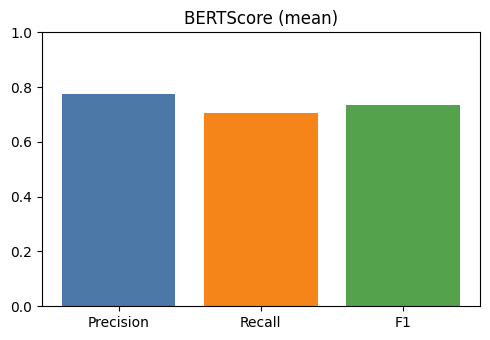

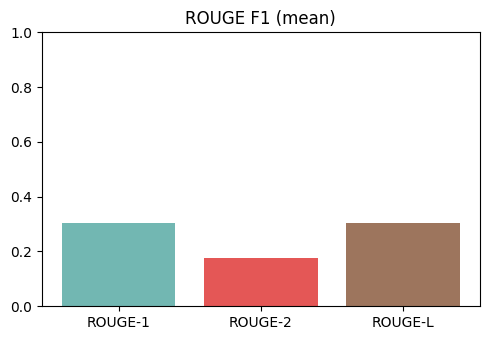

In [21]:
# ==== 10) BERTSCORE + ROUGE =========================================
!pip -q install bert-score rouge-score

from bert_score import score as bertscore
from rouge_score import rouge_scorer
from tqdm.auto import tqdm

# Load best checkpoint before evaluation
if best_path:
    model = Seq2SeqLSTM.load_from_checkpoint(best_path, vocab_size=vocab_size, pad_id=pad_id, cfg=CFG)
    model = model.to("cuda" if torch.cuda.is_available() else "cpu").eval()

@torch.no_grad()
def generate_texts(model, loader, max_len, bos_id, eos_id, pad_id, itos,
                   use_beam=True, beam_size=5, len_norm=0.7):
    refs, hyps = [], []
    device = model.device
    for batch in tqdm(loader, desc="Generating"):
        B = batch["src"].size(0)
        for i in range(B):
            src_ids = batch["src"][i][: batch["src_len"][i]].to(device).long().cpu()
            if use_beam:
                hyp_ids = beam_search_decode(model, src_ids, max_len, bos_id, eos_id,
                                             beam_size=beam_size, len_norm=len_norm)
            else:
                hyp_ids = greedy_decode(model, src_ids, max_len, bos_id, eos_id)
            hyps.append(detokenize(hyp_ids, itos, special_ids=(bos_id, eos_id, pad_id)))
            refs.append(batch["refs"][i])
    return refs, hyps
# @torch.no_grad()
# def generate_texts(model, loader, max_len, bos_id, eos_id, pad_id, itos):
#     refs, hyps = [], []
#     for batch in tqdm(loader, desc="Generating"):
#         B = batch["src"].size(0)
#         for i in range(B):
#             src_ids = batch["src"][i][: batch["src_len"][i]].cpu()
#             hyp_ids = greedy_decode(model, src_ids, max_len, bos_id, eos_id, pad_id)
#             hyps.append(detokenize(hyp_ids, itos, special_ids=(bos_id, eos_id, pad_id)))
#             refs.append(batch["refs"][i])
#     return refs, hyps

refs, hyps = generate_texts(model, test_loader, CFG["max_tgt_len"], bos_id, eos_id, pad_id, itos)

# --- BERTScore (SciBERT is a good default for biomedical text) ---
bio_model = "allenai/scibert_scivocab_uncased"
P, R, F1 = bertscore(hyps, refs, model_type=bio_model,
                     lang="en",
                     device="cuda" if torch.cuda.is_available() else "cpu",
                     rescale_with_baseline=False,
                     batch_size=32,
                     verbose=True)

p_mean, r_mean, f1_mean = float(P.mean()), float(R.mean()), float(F1.mean())
print(f"BERTScore — P: {p_mean:.4f}  R: {r_mean:.4f}  F1: {f1_mean:.4f}")

# --- ROUGE (ROUGE-1/2/L F1) ---
scorer = rouge_scorer.RougeScorer(["rouge1","rouge2","rougeLsum"], use_stemmer=True)
r1_list, r2_list, rl_list = [], [], []
for ref, hyp in zip(refs, hyps):
    s = scorer.score(ref, hyp)
    r1_list.append(s["rouge1"].fmeasure)
    r2_list.append(s["rouge2"].fmeasure)
    rl_list.append(s["rougeLsum"].fmeasure)

r1_mean, r2_mean, rl_mean = float(sum(r1_list)/len(r1_list)), float(sum(r2_list)/len(r2_list)), float(sum(rl_list)/len(rl_list))
print(f"ROUGE — R1: {r1_mean:.4f}  R2: {r2_mean:.4f}  RL: {rl_mean:.4f}")

# --- Plots (explicit colors as requested) ---
import matplotlib.pyplot as plt

# BERTScore bar
plt.figure(figsize=(5,3.5))
plt.bar(["Precision","Recall","F1"], [p_mean, r_mean, f1_mean], color=["#4C78A8","#F58518","#54A24B"])
plt.title("BERTScore (mean)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# ROUGE bar
plt.figure(figsize=(5,3.5))
plt.bar(["ROUGE-1","ROUGE-2","ROUGE-L"], [r1_mean, r2_mean, rl_mean], color=["#72B7B2","#E45756","#9D755D"])
plt.title("ROUGE F1 (mean)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


In [22]:
# # ARCHIVE ==== 10) BERTSCORE EVAL ============================================
# !pip -q install bert-score
# from bert_score import score as bertscore
# from tqdm.auto import tqdm

# # Load best checkpoint for eval
# if best_path:
#     model = Seq2SeqNoAttentionLit.load_from_checkpoint(best_path, vocab_size=vocab_size, pad_id=pad_id, cfg=CFG)
#     model = model.to("cuda" if torch.cuda.is_available() else "cpu").eval()

# @torch.no_grad()
# def generate_texts(model, loader, max_len):
#     hyps, refs = [], []
#     for batch in tqdm(loader, desc="Generating"):
#         B = batch["src"].size(0)
#         for i in range(B):
#             src_ids = batch["src"][i][: batch["src_len"][i]].cpu()
#             hyp_ids = greedy_decode(model, src_ids, max_len, bos_id, eos_id, pad_id)
#             hyps.append(detokenize(hyp_ids))
#             refs.append(batch["refs"][i])
#     return refs, hyps

# refs, hyps = generate_texts(model, test_loader, CFG["max_tgt_len"])

# # Use biomedical encoder (recommended): SciBERT
# bio_model = "allenai/scibert_scivocab_uncased"
# P, R, F1 = bertscore(
#     hyps, refs,
#     model_type=bio_model,
#     lang="en",
#     device="cuda" if torch.cuda.is_available() else "cpu",
#     rescale_with_baseline=False,
#     batch_size=32,
#     verbose=True,
# )
# p_mean, r_mean, f1_mean = float(P.mean()), float(R.mean()), float(F1.mean())
# print(f"BERTScore (SciBERT) — P: {p_mean:.4f}  R: {r_mean:.4f}  F1: {f1_mean:.4f}")

# # --- Simple bar plot of mean metrics ---
# plt.figure(figsize=(5,3.5))
# plt.bar(["Precision","Recall","F1"], [p_mean, r_mean, f1_mean])
# plt.title("BERTScore (mean)")
# plt.ylim(0,1)
# plt.tight_layout()
# plt.show()


## Samples

In [23]:
# ==== 11) TOP/BOTTOM BY BERTSCORE & SAVE CSV ========================
import pandas as pd
df_eval = pd.DataFrame({
    "reference": refs,
    "hypothesis": hyps,
    "bert_precision": P.tolist(),
    "bert_recall": R.tolist(),
    "bert_f1": F1.tolist(),
    "rouge1_f1": r1_list,
    "rouge2_f1": r2_list,
    "rougeL_f1": rl_list,
})

# Sort by BERTScore F1
df_sorted = df_eval.sort_values("bert_f1", ascending=False).reset_index(drop=True)

top10 = df_sorted.head(10).copy()
low10 = df_sorted.tail(10).copy()

# Combine with a label for convenience
top10["which"] = "top10"
low10["which"] = "bottom10"
df_20 = pd.concat([top10, low10], axis=0, ignore_index=True)

# Save
out_csv = "../Data/bert_top10_bottom10.csv"
df_20.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")
df_20.head(5)


Saved: ../Data/bert_top10_bottom10.csv


,reference,hypothesis,bert_precision,bert_recall,bert_f1,rouge1_f1,rouge2_f1,rougeL_f1,which
0,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.0,1.0,1.0,1.0,1.0,1.0,top10
1,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.0,1.0,1.0,1.0,1.0,1.0,top10
2,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.0,1.0,1.0,1.0,1.0,1.0,top10
3,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.0,1.0,1.0,1.0,1.0,1.0,top10
4,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.0,1.0,1.0,1.0,1.0,1.0,top10


In [24]:
# ==== 11) TOP/BOTTOM/MEDIAN BY BERTSCORE & SAVE CSV =================
import pandas as pd
import numpy as np

# Build eval frame (keep a stable row_id so we can avoid duplicates)
df_eval = pd.DataFrame({
    "reference": refs,
    "hypothesis": hyps,
    "bert_precision": P.tolist(),
    "bert_recall": R.tolist(),
    "bert_f1": F1.tolist(),
    "rouge1_f1": r1_list,
    "rouge2_f1": r2_list,
    "rougeL_f1": rl_list,
}).reset_index().rename(columns={"index": "row_id"})

# Sort by BERT F1 (desc) for top/bottom selection
df_sorted = df_eval.sort_values("bert_f1", ascending=False).reset_index(drop=True)

# --- Top / Bottom ---
top10 = df_sorted.head(10).copy()
low10 = df_sorted.tail(10).copy()

top10["which"] = "top10"
low10["which"] = "bottom10"

# --- Median 20: closest to the global median BERT F1, excluding top/bottom ---
median_val = float(df_eval["bert_f1"].median())
candidates = df_eval.copy()
# Exclude any rows already in top/bottom (by row_id)
exclude_ids = set(top10["row_id"]).union(set(low10["row_id"]))
candidates = candidates[~candidates["row_id"].isin(exclude_ids)].copy()

# Distance to median, pick 20 closest
candidates["median_dist"] = (candidates["bert_f1"] - median_val).abs()
median20 = candidates.sort_values(["median_dist", "bert_f1"]).head(20).drop(columns=["median_dist"]).copy()
median20["which"] = "median20"

# --- Combine & Save ---
df_sets = pd.concat([top10, low10, median20], axis=0, ignore_index=True)

out_csv = "../Data/bert_samples_top10_bottom10_median20.csv"
df_sets.to_csv(out_csv, index=False)
print(f"Saved: {out_csv}")
print("Counts ->", df_sets["which"].value_counts().to_dict())

# Optional: quick peek at a few rows from each bucket
def peek(df, label, n=3):
    print(f"\n--- {label} (showing {n}) ---")
    display(df[df["which"] == label][["bert_f1","reference","hypothesis"]].head(n))

peek(df_sets, "top10")
peek(df_sets, "median20")
peek(df_sets, "bottom10")


Saved: ../Data/bert_samples_top10_bottom10_median20.csv
Counts -> {'median20': 20, 'top10': 10, 'bottom10': 10}

--- top10 (showing 3) ---


,bert_f1,reference,hypothesis
0,1.0,No active cardiopulmonary disease.,No active cardiopulmonary disease.
1,1.0,No active cardiopulmonary disease.,No active cardiopulmonary disease.
2,1.0,No active cardiopulmonary disease.,No active cardiopulmonary disease.



--- median20 (showing 3) ---


,bert_f1,reference,hypothesis
20,0.690066,Negative chest.,No active cardiopulmonary disease.
21,0.690066,Negative chest.,No active cardiopulmonary disease.
22,0.690066,Negative chest.,No active cardiopulmonary disease.



--- bottom10 (showing 3) ---


,bert_f1,reference,hypothesis
10,0.495893,1. Coiled orogastric tube. 2. RDS. 3. The find...,No active cardiopulmonary disease.
11,0.493485,The right IJ approach central venous catheter ...,No active cardiopulmonary disease.
12,0.492366,Interval development of large left pneumothora...,No active cardiopulmonary disease.


In [25]:
df_20

,reference,hypothesis,bert_precision,bert_recall,bert_f1,rouge1_f1,rouge2_f1,rougeL_f1,which
0,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
1,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
2,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
3,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
4,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
5,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
6,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
7,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
8,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10
9,No active cardiopulmonary disease.,No active cardiopulmonary disease.,1.000000,1.000000,1.000000,1.0,1.0,1.0,top10


In [26]:
# # ARCHIVE ==== 11) SAMPLES ====================================================
# for i in range(3):
#     row = test_df.iloc[i]
#     src_ids = torch.tensor(numericalize(row["source_text"], CFG["max_src_len"]), dtype=torch.long)
#     hyp_ids = greedy_decode(model, src_ids, CFG["max_tgt_len"], bos_id, eos_id, pad_id)
#     print("="*80)
#     print("SOURCE:\n", row["source_text"][:800])
#     print("\nREFERENCE:\n", row["target_text"][:800])
#     print("\nHYPOTHESIS:\n", detokenize(hyp_ids)[:800])
